In [1]:
import numpy as np
import matplotlib.pyplot as plt
from inktime import rgbkm
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import cv2

In [2]:
# Load in Red Fuji
img = Image.open("red_fuji.jpg") # Shape (x,y,RGB)
img = np.array(img)/255.0

height, width, _ = img.shape

## Di-Zenzo color gradient formulation

Calculating the gradients using the Sobel kernels. These can be decomposed as the products of an averaging and a differentiation kernel, they compute the gradient with smoothing. Calculate the gradient of the image ($I$) in each channel both in the x and y direction. Use pythogoras to calculate total gradient. The edges are were the gradient is above a certain threshold.

$ \lVert \nabla I(x,y) \rVert =\sqrt{\sum_{c \in \{L,a,b\}} \left(\left( \frac{\partial I_c}{\partial x} \right)^2+\left( \frac{\partial I_c}{\partial y} \right)^2\right)}$

I calculate the gradients in Lab space because distances there represent perceived color distances more accurately than RGB. I assume daylight D65.

In [6]:

def sobel_gradient(img_rgb, ksize=3, sigma = 0.5):
    """
    Lab vector gradient magnitude.

    Parameters:
    img_rgb : Input RGB image (H, W, 3) uint8
    ksize : Sobel kernel size int (3-5)
    threshold : Threshold in [0,1] after normalization

    Returns:
    magnitude : Gradient magnitude (H, W) float32
    """

    # RGB -> Lab (OpenCV uses D65, sobel needs floating points)
    # Each point is a vector in R^3
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
    lab = cv2.GaussianBlur(lab, (0, 0), 0.5)

    # Compute spatial gradients per channel c = l, a, b
    gx = np.zeros(lab.shape[:2], dtype=np.float32) # gradient in x direction
    gy = np.zeros(lab.shape[:2], dtype=np.float32) # gradient in y direction

    for c in range(3):
        gx_c = cv2.Sobel(lab[:, :, c], cv2.CV_32F, 1, 0, ksize=ksize)
        gy_c = cv2.Sobel(lab[:, :, c], cv2.CV_32F, 0, 1, ksize=ksize)
        gx += gx_c ** 2 
        gy += gy_c ** 2

    # Vector gradient magnitude
    magnitude = np.sqrt(gx + gy)

    # Normalize gradient magnitude
    magnitude /= magnitude.max() + 1e-8

    return magnitude


In [8]:
img = cv2.imread('red_fuji.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mag = sobel_gradient(img)

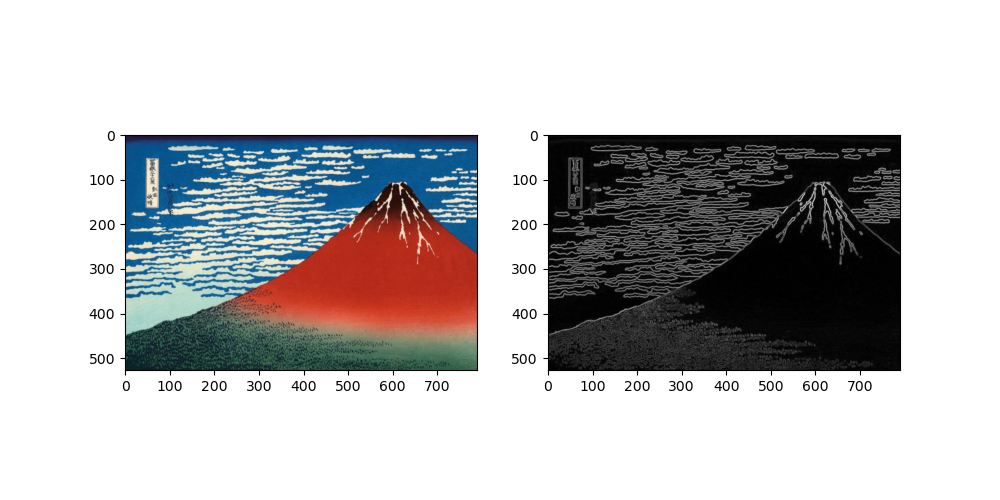

In [10]:
%matplotlib widget

plt.close()
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(mag, cmap = 'gray')
plt.show()

### Watershed + merge regions based on color

In [13]:
from scipy.ndimage import gaussian_filter, distance_transform_edt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.morphology import h_minima
from skimage.segmentation import felzenszwalb

def watershed_gradient(gradient,
    grad_threshold=0.15,
    min_distance=1,
    distance_threshold=1,
    min_region_size=1
    ):
    
    """
    Watershed segmentation from a gradient magnitude image.
    """
    
    # Define barriers (high gradient = boundary)
    barriers = gradient > grad_threshold

    # Distance transform from barriers
    distance = distance_transform_edt(~barriers)

    # Extract markers from distance peaks
    coords = peak_local_max(distance, min_distance=min_distance, threshold_abs=distance_threshold)

    markers = np.zeros(distance.shape, dtype=np.int32)
    for i, (y, x) in enumerate(coords, start=1):
        markers[y, x] = i

    # Watershed flooding
    labels = watershed(gradient, markers, watershed_line=False)

    return labels, distance


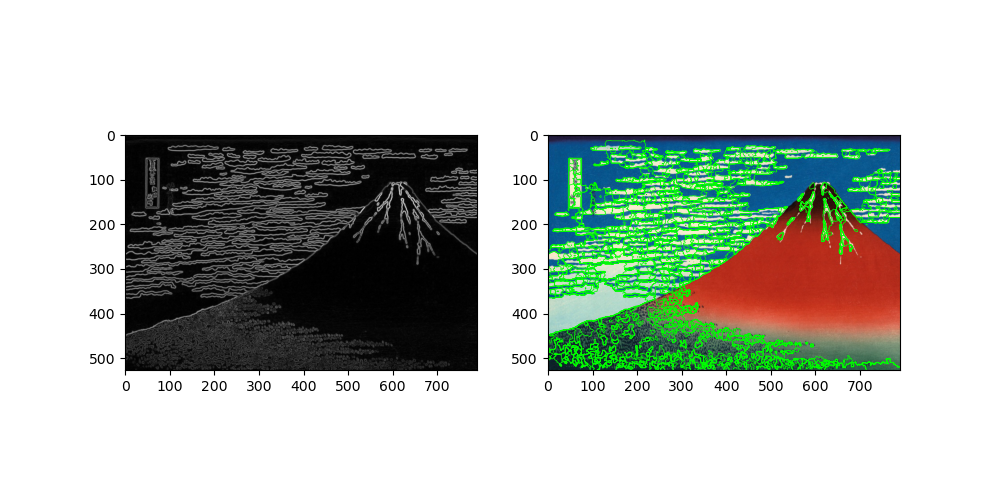

In [15]:
labels, distance = watershed_gradient(mag)
plt.close()

fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(mag, cmap = 'gray')
ax[1].imshow(img)
ax[1].contour(labels, colors='lime', linewidths=0.5)
plt.show()

In [17]:
from skimage import graph
from skimage.color import rgb2lab

def merge_similar_regions(img_rgb, labels, color_thresh=15.0):

    lab = rgb2lab(img_rgb)

    # Build region adjacency graph (RAG)
    rag = graph.rag_mean_color(lab, labels)

    # Merge if color distance small
    labels_merged = graph.cut_threshold(labels, rag, thresh=color_thresh)

    return labels_merged


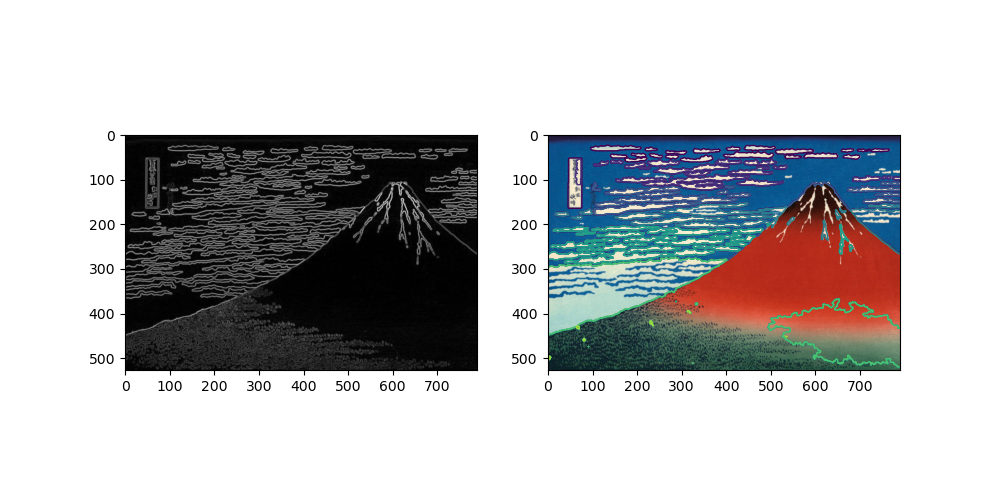

In [19]:
labels_merged = merge_similar_regions(img, labels)

plt.close()
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(mag, cmap = 'gray')
ax[1].imshow(img)
ax[1].contour(labels_merged, linewidths=1)
plt.show()

### Felzenswalb of zo

In [22]:
from skimage.segmentation import felzenszwalb

def felzenszwalb_lab(img_rgb, scale=150, sigma=0.8, min_size=100):

    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)

    labels = felzenszwalb(
        lab,
        scale=scale,
        sigma=sigma,
        min_size=min_size
    )

    return labels

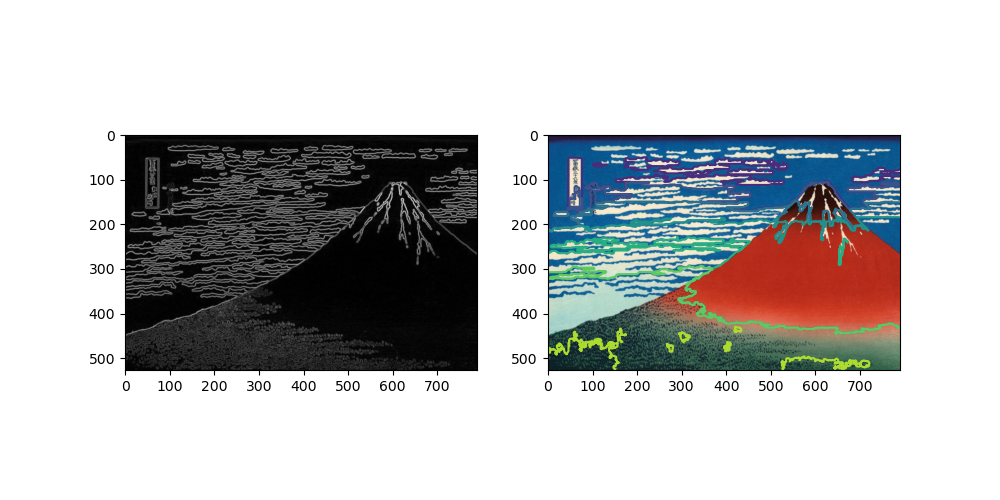

In [24]:
labels = felzenszwalb_lab(img)

plt.close()
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(mag, cmap = 'gray')
ax[1].imshow(img)
ax[1].contour(labels)
plt.show()

## Back to K-means/ clustering

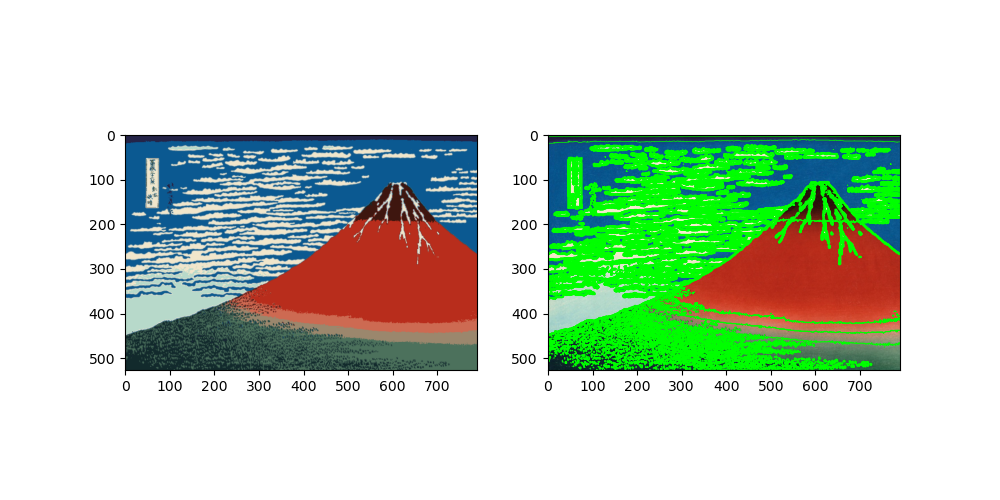

In [27]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage.color import rgb2lab, label2rgb
from skimage.filters import sobel
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


h, w, _ = img.shape

image_lab = rgb2lab(img) # from RGB to Lab
grad = sobel_gradient(img) # compute gradient

yy, xx = np.mgrid[0:h, 0:w] # spatial grid


lambda_s = 0.0    # spatial weight
lambda_c = 1.0     # color weight
lambda_g = 10.0      # edge weight

features = np.stack([
    #lambda_s * xx,
    #lambda_s * yy,
    lambda_c * image_lab[:, :, 0],
    lambda_c * image_lab[:, :, 1],
    lambda_c * image_lab[:, :, 2],
    lambda_g * grad
], axis=-1)

# Flatten to (N_pixels, N_features)
X = features.reshape(-1, 4)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#K-means
n_clusters = 18   # adjust

kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
labels = kmeans.fit_predict(X_scaled)
labels = labels.reshape(h, w)

def region_median_color(image, labels):
    out = np.zeros_like(image)
    for label in np.unique(labels):
        mask = labels == label
        for c in range(3):
            out[:, :, c][mask] = np.median(image[:, :, c][mask])
    return out

segmented = region_median_color(img, labels)

plt.close()
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(segmented)
ax[1].imshow(img)
ax[1].contour(labels, colors='lime', linewidths=0.5)
plt.show()



### Toch maar UMAP...

In [ ]:
h, w, _ = img.shape

image_lab = rgb2lab(img) # from RGB to Lab
grad = sobel_gradient(img) # compute gradient

yy, xx = np.mgrid[0:h, 0:w] # spatial grid

features = np.stack([xx, yy, image_lab[:, :, 0], image_lab[:, :, 1], image_lab[:, :, 2], grad], axis=-1)

# Flatten to (N_pixels, N_features)
features_flat = features.reshape(-1, 6)

import umap

reducer = umap.UMAP(n_neighbors=50, min_dist=0.0, n_components=2, random_state=42)
embedding = reducer.fit_transform(features_flat)




/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
subset = np.random.choice(len(embedding), size=10000, replace=False)
plt.scatter(embedding[subset,0], embedding[subset,1], s=1)

plt.close()
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax[0].scatter(embedding[subset, 0], embedding[subset, 1])

plt.show()